# TREMBA TRANSFER ON 15 SCENES
https://openreview.net/forum?id=SJxhNTNYwB

On prend le générateur entraîné sur ImageNet et on vérifie la transférabilité du modèle en le testant sur le dataset 15 - Scenes

In [0]:
%matplotlib inline
import argparse
import os
import time

import torch.backends.cudnn as cudnn
from torch import nn
import torch.nn.parallel
import torch.utils.data
import torchvision.models as models
from PIL import Image
from torch.nn import functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.nn import functional as F
import torchvision
import numpy as np

from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


In [0]:
!wget https://webia.lip6.fr/~douillard/rdfia/tp8.zip
!unzip /content/tp8.zip

--2020-02-10 14:25:50--  https://webia.lip6.fr/~douillard/rdfia/tp8.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86574454 (83M) [application/zip]
Saving to: ‘tp8.zip’

tp8.zip             100%[===================>]  82.56M  21.6MB/s    in 4.7s    

2020-02-10 14:25:55 (17.5 MB/s) - ‘tp8.zip’ saved [86574454/86574454]

Archive:  /content/tp8.zip
   creating: tp8/
  inflating: tp8/transfer.py         
  inflating: tp8/imagenet_classes.pkl  
   creating: tp8/15SceneData/
   creating: tp8/15SceneData/train/
   creating: tp8/15SceneData/train/forest/
 extracting: tp8/15SceneData/train/forest/image_0309.jpg  
 extracting: tp8/15SceneData/train/forest/image_0103.jpg  
 extracting: tp8/15SceneData/train/forest/image_0324.jpg  
  inflating: tp8/15SceneData/train/forest/image_0283.jpg  
 extracting: tp8/15SceneData/train/forest/image_0182.jpg  
 ex

## Dataset : 15 SCENES

In [0]:
def get_dataset(batch_size, path):

    def duplicateChannel(img):
        # Cette fonction permet de recopier 3 fois une image qui
        # ne serait que sur 1 channel (donc image niveau de gris)
        # pour la "transformer" en image RGB. Utilisez la avec
        # transform.Lambda
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    mu,sigma = [0.485,0.456,0.406],[0.229,0.224,0.225]
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # TODO Pré-traitement à faire
            transforms.Resize(256),                    #[2]
            transforms.CenterCrop(224), 
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),
            transforms.Normalize(mu,sigma, inplace=True)
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # TODO Pré-traitement à faire
            transforms.Resize(256),                    #[2]
            transforms.CenterCrop(224),
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),
            transforms.Normalize(mu,sigma, inplace=True)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False)

    return train_loader, val_loader,len(train_dataset),len(val_dataset)

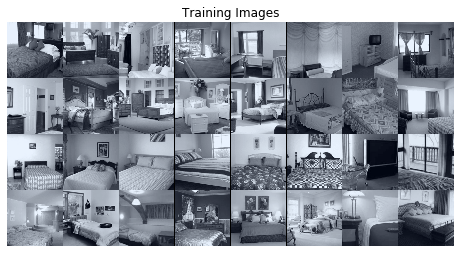

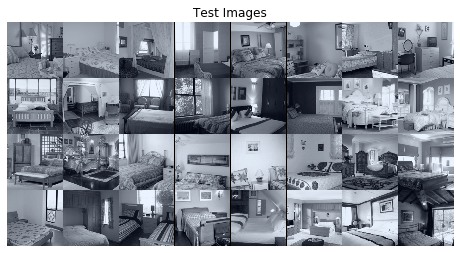

In [27]:
# We can use an image folder dataset the way we have it setup.



# Get the dataloaders
batch_size = 32
dataloader_train, dataloader_test,len_train,len_test  = get_dataset(batch_size=batch_size,path="/content/tp8/15SceneData")
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
# Plot some test images
real_batch = next(iter(dataloader_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Transfer learning from VGG16 ImageNet to 15Scene

In [0]:
print('Instanciation de VGG16')
vgg16 = models.vgg16(pretrained=True)



Instanciation de VGG16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [23]:
class VGG16relu7(torch.nn.Module):
    def __init__(self,vgg16):
        super(VGG16relu7,self).__init__()
        self.features = torch.nn.Sequential(*list(vgg16.features.children()))
        self.classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-2])


    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x 

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
class MLP_15Scene(torch.nn.Module):
  def __init__(self):
    super(MLP_15Scene,self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(4096,256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.25),
        nn.Linear(256,15)
    )

  def forward(self,x):
    return self.classifier(x)



In [0]:
features_extract = VGG16relu7(vgg16)
features_extract.to(device)
model = MLP_15Scene()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
epochs = 100

In [0]:
fcnet_train_loss = []
fcnet_test_loss = []
fcnet_train_prec = []
fcnet_test_prec = []
fcnet_mean_train_loss = []
fcnet_mean_test_loss = []
nb_train = len_train
nb_test = len_test

In [31]:
print("------ TRAINING FCNET ------")
for ep in range(epochs):
  sum_train = 0
  sum_test = 0
  print("------ EPOCHS",ep,"------")
  for i,(x,y) in enumerate(dataloader_train):
    features_extract.eval()
    model.train()
    optimizer.zero_grad()
    x = x.to(device)
    x = features_extract(x)
    y = y.to(device)
    output = model(x)
    loss = criterion(output, y)
    fcnet_train_loss.append(float(loss))
    sum_train+= int(torch.sum(torch.argmax(output,1)==y))
    loss.backward()
    optimizer.step()

  fcnet_mean_train_loss.append(np.array(fcnet_train_loss[i:]).mean())
  print("AVERAGE LOSS TRAIN FOR EPOCH",ep,":",round(np.array(fcnet_train_loss[i:]).mean(),2))
  prec = sum_train/nb_train
  print("PRECISION TRAIN EPOCH",ep,":",round(prec,2))
  fcnet_train_prec.append(prec)


  for i,(x,y) in enumerate(dataloader_test):
    features_extract.eval()
    model.eval()
    with torch.no_grad():
      x = x.to(device)
      x = features_extract(x)
      y = y.to(device)
      output = model(x)
      loss = criterion(output, y.view(-1))
      fcnet_test_loss.append(float(loss))
      sum_test+= int(torch.sum(torch.argmax(output,1)==y))

  fcnet_mean_test_loss.append(np.array(fcnet_test_loss[i:]).mean())
  print("AVERAGE LOSS TEST FOR EPOCH",ep,":",round(np.array(fcnet_test_loss[i:]).mean(),2))
  prec = sum_test/nb_test
  print("PRECISION TEST EPOCH:",ep,":",round(prec,2))
  fcnet_test_prec.append(prec)

------ TRAINING FCNET ------
------ EPOCHS 0 ------
AVERAGE LOSS TRAIN FOR EPOCH 0 : 2.81
PRECISION TRAIN EPOCH 0 : 0.05
AVERAGE LOSS TEST FOR EPOCH 0 : 2.78
PRECISION TEST EPOCH: 0 : 0.28
------ EPOCHS 1 ------
AVERAGE LOSS TRAIN FOR EPOCH 1 : 2.44
PRECISION TRAIN EPOCH 1 : 0.13
AVERAGE LOSS TEST FOR EPOCH 1 : 2.02
PRECISION TEST EPOCH: 1 : 0.43
------ EPOCHS 2 ------
AVERAGE LOSS TRAIN FOR EPOCH 2 : 2.28
PRECISION TRAIN EPOCH 2 : 0.25
AVERAGE LOSS TEST FOR EPOCH 2 : 1.83
PRECISION TEST EPOCH: 2 : 0.51
------ EPOCHS 3 ------
AVERAGE LOSS TRAIN FOR EPOCH 3 : 2.13
PRECISION TRAIN EPOCH 3 : 0.31
AVERAGE LOSS TEST FOR EPOCH 3 : 1.68
PRECISION TEST EPOCH: 3 : 0.55
------ EPOCHS 4 ------
AVERAGE LOSS TRAIN FOR EPOCH 4 : 1.98
PRECISION TRAIN EPOCH 4 : 0.36
AVERAGE LOSS TEST FOR EPOCH 4 : 1.55
PRECISION TEST EPOCH: 4 : 0.64
------ EPOCHS 5 ------
AVERAGE LOSS TRAIN FOR EPOCH 5 : 1.84
PRECISION TRAIN EPOCH 5 : 0.47
AVERAGE LOSS TEST FOR EPOCH 5 : 1.42
PRECISION TEST EPOCH: 5 : 0.72
------ EPOC

KeyboardInterrupt: ignored

Text(0, 0.5, 'Loss')

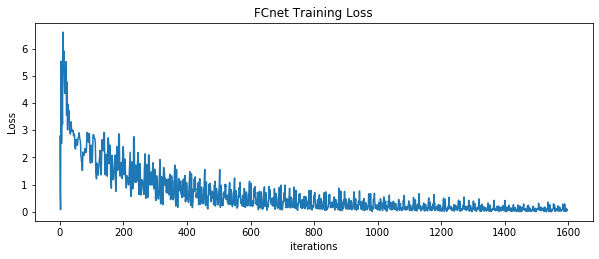

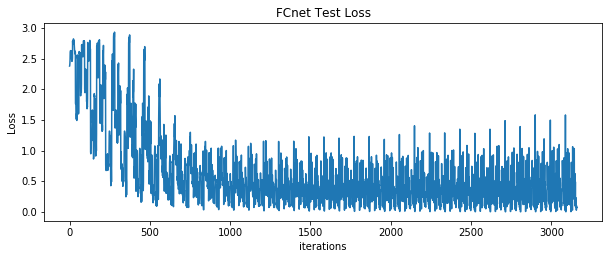

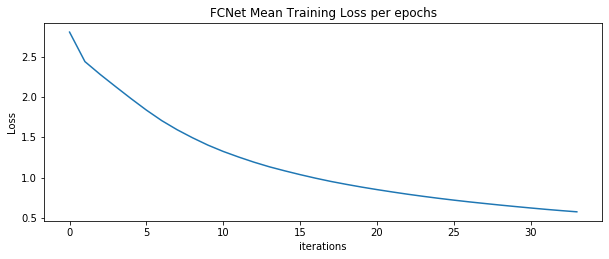

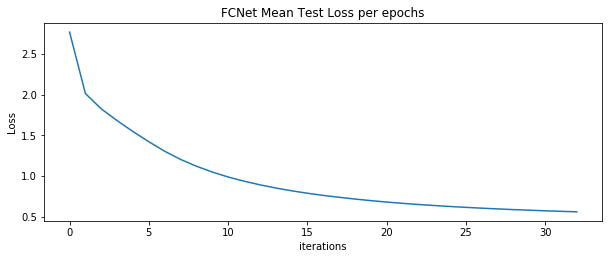

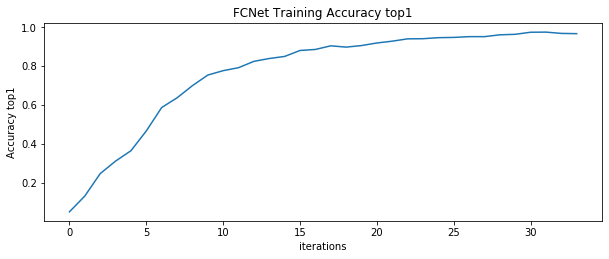

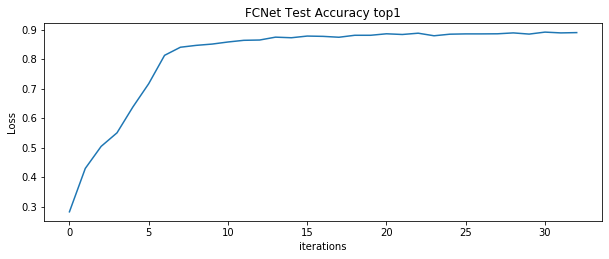

In [32]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCnet Training Loss")
plt.plot(fcnet_train_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCnet Test Loss")
plt.plot(fcnet_test_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNet Mean Training Loss per epochs")
plt.plot(fcnet_mean_train_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNet Mean Test Loss per epochs")
plt.plot(fcnet_mean_test_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNet Training Accuracy top1")
plt.plot(fcnet_train_prec)
plt.xlabel("iterations")
plt.ylabel("Accuracy top1")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNet Test Accuracy top1")
plt.plot(fcnet_test_prec)
plt.xlabel("iterations")
plt.ylabel("Loss")

In [33]:
torch.save(model,'15Scene_classifier.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP_15Scene. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
